* * *
<pre> NYU Paris            <i> Artificial intelligence - Fall 2023 </i></pre>
* * *


<h1 align="center"> Lab 5: Model complexity and model selection </h1>

<pre align="left"> September 28th 2023               <i> Author: Hicham Janati </i></pre>
* * *


##### Goals:
- Know when the model underfits and overfits and act accordingly
- Perform hyperparameter tuning using cross validation
- Use scikit-learn pipelines to streamline machine learning steps

## 1 - Reading and visualizing data 


First we load a dataset of images of famous persons and visualize some examples.

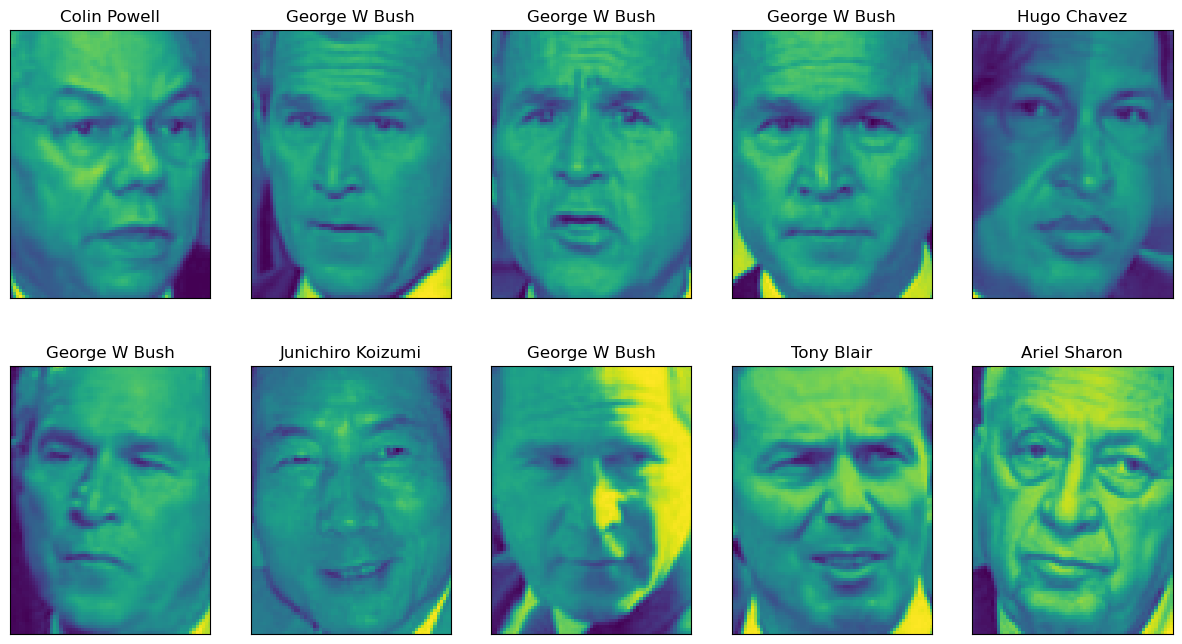

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt

people = fetch_lfw_people(min_faces_per_person=60, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
    


In [2]:
print(people)

{'data': array([[0.5281046 , 0.52156866, 0.50980395, ..., 0.01045752, 0.00653595,
        0.00130719],
       [0.30849674, 0.2509804 , 0.20261438, ..., 0.95032686, 0.945098  ,
        0.93071896],
       [0.28366014, 0.37385622, 0.37777779, ..., 0.71503276, 0.93333334,
        0.94640523],
       ...,
       [0.11633987, 0.11372549, 0.11503268, ..., 0.58431375, 0.5777778 ,
        0.5424837 ],
       [0.19477125, 0.19607843, 0.2248366 , ..., 0.65228766, 0.6562092 ,
        0.5411765 ],
       [0.12810458, 0.10980392, 0.09411765, ..., 0.14901961, 0.20392157,
        0.3385621 ]], dtype=float32), 'images': array([[[0.5281046 , 0.52156866, 0.50980395, ..., 0.2627451 ,
         0.26143792, 0.25620916],
        [0.5503268 , 0.5607843 , 0.53464055, ..., 0.2653595 ,
         0.2627451 , 0.26143792],
        [0.57647055, 0.5633987 , 0.52026147, ..., 0.26143792,
         0.25882354, 0.26143792],
        ...,
        [0.4117647 , 0.724183  , 0.80522877, ..., 0.00653595,
         0.00653595, 0.00

Some information about the dataset can be obtained by getting the documentation of the fetch function:

In [3]:
help(fetch_lfw_people)

Help on function fetch_lfw_people in module sklearn.datasets._lfw:

fetch_lfw_people(*, data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)
    Load the Labeled Faces in the Wild (LFW) people dataset (classification).
    
    Download it if necessary.
    
    =================   =======================
    Classes                                5749
    Samples total                         13233
    Dimensionality                         5828
    Features            real, between 0 and 255
    =================   =======================
    
    Read more in the :ref:`User Guide <labeled_faces_in_the_wild_dataset>`.
    
    Parameters
    ----------
    data_home : str, default=None
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    funneled : boo

We print data shapes info:

In [4]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (1348, 87, 65)
Number of classes: 8


We have 62 different persons in the dataset with a total of 3023 images of shape (87x65).

### Question 0
Count how many each person appears in the dataset. 

Hint: Look up the function `np.bincount`

In [ ]:
print(people.target)

In [5]:
np.bincount(people.target)

array([ 77, 236, 121, 530, 109,  71,  60, 144])

In [14]:
#EXTRA
print(people.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


We reshape the images the dataset to be of the form (n_samples x n_features)

In [6]:
#

X = people.images.reshape(len(people.images), -1)
y = people.target
X.min(), X.max(), X[0]

(0.0,
 1.0,
 array([0.5281046 , 0.52156866, 0.50980395, ..., 0.01045752, 0.00653595,
        0.00130719], dtype=float32))

The image values are between 0 and 255. We rescale them to 0-1.

In [7]:
X = X / 255

### Question 1
Split the dataset into train and test (80% train). Look up the documentation of `train_test_split` to make sure the frequency of each label is respected in the splits. If you wrote a naive classifier that predicts the target of the person by picking a number randomly (uniformly). What would be its prediction score ? 

This would be our score baseline i.e the performance of chance.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=None)


num_classes = len(np.unique(y))
baseline_accuracy = 1 / num_classes 

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Accuracy: 0.1250


### Question 2

We start with making predictions with a K-nearest-neighbors (kNN) model. KNN predicts the target (the identity of the person) based on the majority vote of the target of the K closest images to it. Here we define "close" by computing a simple squared euclidean distance between the images.

Fit a k-NN with k [1, 2, 3, 4, 5] and compute its prediction score for train and test. How do you explain this result ? Does it overfit or underfit ?

In [9]:
from sklearn.neighbors import KNeighborsClassifier

k_values=[1,2,3,4,5]

# neigh=KNeighborsClassifier(n_neighbors=k_values)
# neigh.fit(X,y)

# neigh.predict([[1.1]])


for k in k_values:
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(X_train, y_train)
   y_test_pred = classifier.predict(X_test)
   y_train_pred = classifier.predict(X_train)
   
   train_accuracy = classifier.score(X_train, y_train)
   test_accuracy = classifier.score(X_test, y_test)

   print(f'k={k}: Test Accuracy = {test_accuracy:.4f} Train Accuracy={train_accuracy:.4f}')

k=1: Test Accuracy = 0.5222 Train Accuracy=1.0000
k=2: Test Accuracy = 0.4889 Train Accuracy=0.7746
k=3: Test Accuracy = 0.5259 Train Accuracy=0.7672
k=4: Test Accuracy = 0.5111 Train Accuracy=0.7393
k=5: Test Accuracy = 0.5259 Train Accuracy=0.7171


In [ ]:
# The kNN model is overfitting because Train accuracy is higher than testing accuracy. 
# With a small k the model is too sensitive to a lot of outside variables which leads 
# to poor generalization on the test data so the test data is less accurate.

### Question
Display its train and test accuracy as a function of the number of train samples. Keep the number of test samples unchaned.

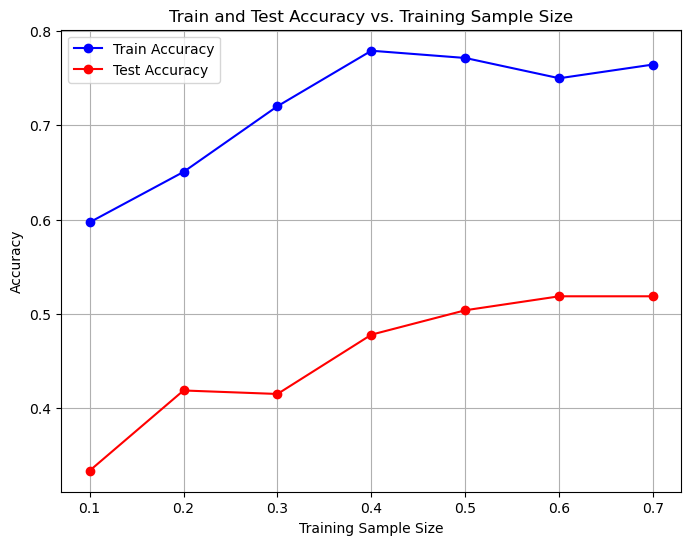

In [10]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Create a PCA object to reduce the dimensionality to 100 components
n_components = 100
pca = PCA(n_components=n_components)

# Fit PCA to the data and transform it
X_pca = pca.fit_transform(X)

# Vary the number of training samples
sample_sizes = np.arange(0.1, 0.8, 0.1) 
train_accuracies = []
test_accuracies = []

for sample_size in sample_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=sample_size, random_state=42)

    k = 3  
    classifier = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    #Training and testing data
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, train_accuracies, marker='o', label='Train Accuracy', color='b')
plt.plot(sample_sizes, test_accuracies, marker='o', label='Test Accuracy', color='r')
plt.title('Train and Test Accuracy vs. Training Sample Size')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Question 3
Compute knn scores but this time do a PCA before to reduce the dimensionality of the data to 100 components

In [10]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_components = 100  # Number of PCA components

# Fit PCA to the training data and transform both training and test data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

k_values = [1, 2, 3, 4, 5]
train_accuracies=[]
test_accuracies=[]

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_pca, y_train)
    y_test_pred = classifier.predict(X_test_pca)
    y_train_pred = classifier.predict(X_train_pca)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'k={k}: Test Accuracy = {test_accuracy:.4f} Train Accuracy={train_accuracy:.4f}')


k=1: Test Accuracy = 0.4926 Train Accuracy=1.0000
k=2: Test Accuracy = 0.4667 Train Accuracy=0.7709
k=3: Test Accuracy = 0.5037 Train Accuracy=0.7603
k=4: Test Accuracy = 0.5074 Train Accuracy=0.7285
k=5: Test Accuracy = 0.4963 Train Accuracy=0.7232


### Question 4 
Repeat this operation but set the PCA argument `whiten` to True. What do you notice ? How do you explain it ?

In [11]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_components = 100  # Number of PCA components

# Fit PCA to the training data and transform both training and test data with whitening
pca = PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

k_values = [1, 2, 3, 4, 5]

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_pca, y_train)
    y_test_pred = classifier.predict(X_test_pca)
    y_train_pred = classifier.predict(X_train_pca)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f'k={k}: Test Accuracy = {test_accuracy:.4f} Train Accuracy={train_accuracy:.4f}')


k=1: Test Accuracy = 0.6296 Train Accuracy=1.0000
k=2: Test Accuracy = 0.5222 Train Accuracy=0.8155
k=3: Test Accuracy = 0.6074 Train Accuracy=0.8144
k=4: Test Accuracy = 0.6185 Train Accuracy=0.8218
k=5: Test Accuracy = 0.6037 Train Accuracy=0.7996


In [ ]:
#Accuracies from previous question for me to compare easily
# k=1: Test Accuracy = 0.5074 Train Accuracy=1.0000
# k=2: Test Accuracy = 0.4778 Train Accuracy=0.7699
# k=3: Test Accuracy = 0.5111 Train Accuracy=0.7646
# k=4: Test Accuracy = 0.5037 Train Accuracy=0.7306
# k=5: Test Accuracy = 0.5037 Train Accuracy=0.7243

#Repeat this operation but set the PCA argument whiten to True. What do you notice ? How do you explain it ?
#ANSWER:
# Enabling whiten has improved test accuracy for all values of k. The model's performance 
# is more balanced between the training and test datasets. 
# The decrease in train accuracy suggests that the model is less prone to overfitting.

### Question 5
Look up the attributes of the PCA object and visualize the first 10 components (as images).

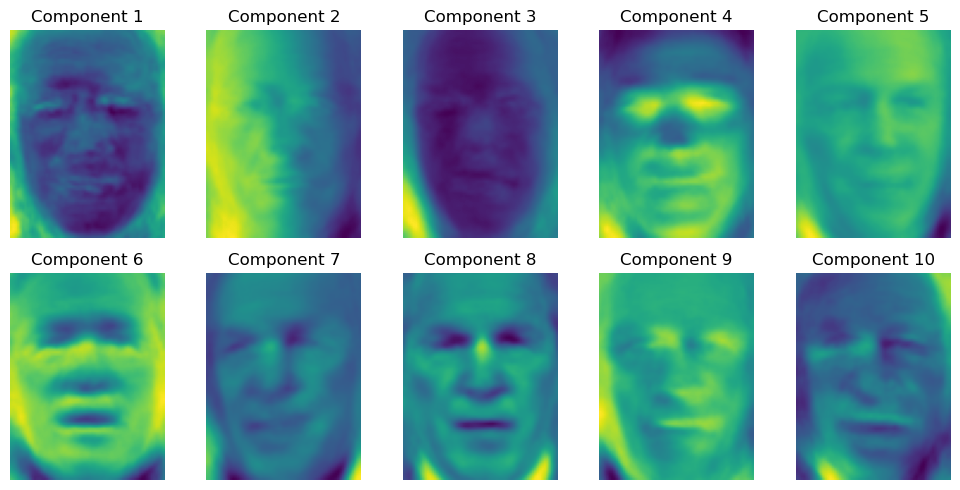

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA object and fit it to your data
n_components = 100  # Number of PCA components
pca = PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train)

# Access the principal components
components = pca.components_

# Visualize the first 10 principal components as images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(components[i].reshape(image_shape), cmap='viridis')
    plt.title(f'Component {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Question 6
We can automatize the choice of K by performing cross-validation:

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
params = {'n_neighbors': [2, 5, 10]}
clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

y_pred = clf.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.42      0.32        12
           1       0.57      0.65      0.61        51
           2       0.37      0.28      0.32        25
           3       0.53      0.76      0.62        98
           4       0.40      0.10      0.15        21
           5       0.33      0.07      0.11        15
           6       0.50      0.50      0.50        10
           7       0.53      0.24      0.33        38

    accuracy                           0.50       270
   macro avg       0.44      0.37      0.37       270
weighted avg       0.49      0.50      0.47       270



You can look up the best performing model:

In [14]:
clf.best_estimator_

KNeighborsClassifier()

We would like to optimize over the choice of PCA n_components as well. To do this we 
 can streamline the PCA + classifier operation by creating a pipeline object. And pass it to the GridSearchCV object with key-coded parameters named like this:

In [15]:
from sklearn.pipeline import Pipeline

model = Pipeline([('pca', PCA()),
                  ('classifier', KNeighborsClassifier()
)])

params = {'pca__n_components': [100, 800], 'classifier__n_neighbors': [2]}


What are the best choices of n_components and k ?

In [16]:
grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy')

#We want our model to have more pixels

grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best n_components: {best_params["pca__n_components"]}')
print(f'Best k (n_neighbors): {best_params["classifier__n_neighbors"]}')




/Users/lilyque/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilyque/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilyque/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lilyque/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line

Best n_components: 100
Best k (n_neighbors): 2


### Question 7
We move on to a different kind of model. We start with a simple linear classifier (LDA). 
Compute its performance (accuracy) with and without PCA. What do you notice ? Use a pipeline.

Interpret the results. What can you say about model complexity of LDA ? What should we do to improve the performance ?

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Create a pipeline with LDA
lda_model = Pipeline([
    ('classifier', LinearDiscriminantAnalysis())
])

# Fit and evaluate the LDA model without PCA
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)
accuracy_no_pca = accuracy_score(y_test, y_pred)

# Create a pipeline with PCA and LDA
pca_lda_model = Pipeline([
    ('pca', PCA(n_components=100)),  # You can choose an appropriate n_components value
    ('classifier', LinearDiscriminantAnalysis())
])

# Fit and evaluate the LDA model with PCA
pca_lda_model.fit(X_train, y_train)
y_pred_pca = pca_lda_model.predict(X_test)
accuracy_with_pca = accuracy_score(y_test, y_pred_pca)

print(f'Accuracy without PCA: {accuracy_no_pca:.4f}')
print(f'Accuracy with PCA: {accuracy_with_pca:.4f}')


Accuracy without PCA: 0.7630
Accuracy with PCA: 0.8593


In [ ]:
# When LDA is applied directly to the original data it achieves an accuracy of 0.7630. 
# This means that the LDA is able to capture and differentiate between class information 
# in the data with a relatively good accuracy.

#When LDA is applied to data that has been pre-processed with PCA the accuracy improves to 0.8593. 
#I think this means that PCA preprocessing has had a positive impact on the LDA model's performance.

### Question 8
Repeat the operation with a random forest classifier. What do you notice ?

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# with the Random Forest classifier
rf_model = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# without PCA
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_no_pca_rf = accuracy_score(y_test, y_pred_rf)

# with PCA AND the Random Forest classifier
pca_rf_model = Pipeline([
    ('pca', PCA(n_components=100)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit and evaluate the Random Forest model with PCA
pca_rf_model.fit(X_train, y_train)
y_pred_pca_rf = pca_rf_model.predict(X_test)
accuracy_with_pca_rf = accuracy_score(y_test, y_pred_pca_rf)

print(f'Random Forest Accuracy without PCA: {accuracy_no_pca_rf:.4f}')
print(f'Random Forest Accuracy with PCA: {accuracy_with_pca_rf:.4f}')



Random Forest Accuracy without PCA: 0.6000
Random Forest Accuracy with PCA: 0.5370


In [ ]:
# Without PCA, the Random Forest achieved an accuracy of 0.6000. 
# I think this means that the Random Forest is capable of capturing 
# some of the patterns and relationships within the dataset.

# When PCA is applied before using the Random Forest classifier the accuracy drops to 0.5370. 
# I think this means that PCA doesn't work for this specific dataset when using Random Forest.

### Question 9
Look up its hyperparameters (`min_samples_leaf`, `n_estimators`, `max_depth` etc). Tune the values of these these hyperparameters using GridSearchCV. Can you beat the LDA method ?

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2] 
}

# Create a Random Forest pipeline with PCA
rf_model = Pipeline([
    ('pca', PCA(n_components=100)),  # You can choose an appropriate n_components value
    ('classifier', RandomForestClassifier(random_state=42))
])

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_


best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)

print(f'Best Random Forest Accuracy on Training Data: {best_score_rf:.4f}')
print(f'Random Forest Accuracy on Test Data (Best Model): {accuracy_rf_best:.4f}')

# Compare with the LDA method
print(f'Accuracy with LDA (PCA): {accuracy_with_pca:.4f}')


Best Random Forest Accuracy on Training Data: 0.5398
Random Forest Accuracy on Test Data (Best Model): 0.5111
Accuracy with LDA (PCA): 0.8593


In [ ]:
#In my opinion, it is not possible to beat the accuracy of LDA. As we can see, with Random forest accuracy, I only got
# 0.53 which is comparatively low to the LDA accuracy of 0.8593.
#The dataset is suited for LDA rather than random forest.

### Question 10
GradientBoosting methoda are optimized versions of RandomForests where trees are added to the forest sequentially by picking "optimal" trees to add. Optimize their hyperparameters and compare with random forests.

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


param_grid_gb = {
    'n_estimators': [50], 
    'learning_rate': [0.1, 0.01], 
    'max_depth': [3], 
    'min_samples_split': [2],
    'min_samples_leaf': [1]  
}

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train)

# Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, cv=3, scoring='accuracy')

grid_search_gb.fit(X_train_pca, y_train)


best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_


X_test_pca = pca.transform(X_test)

# Evaluate the Gradient Boosting model
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_best = best_gb_model.predict(X_test_pca)
y_pred_rf_best = best_gb_model.predict(X_test_pca)
          
accuracy_gb_best = accuracy_score(y_test, y_pred_gb_best)
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)

print(f'Best Gradient Boosting Parameters: {best_params_gb}')
print(f'Best Gradient Boosting Accuracy on Training Data with PCA: {best_score_gb:.4f}')
print(f'Gradient Boosting Accuracy on Test Data with PCA (Best Model): {accuracy_gb_best:.4f}')


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Gradient Boosting Accuracy on Training Data with PCA: 0.5939
Gradient Boosting Accuracy on Test Data with PCA (Best Model): 0.6037


### Question 11
